In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns


In [2]:
# Load data
df     = pd.read_csv('data/bbs/bbs2011.csv')
df2    = pd.read_csv('data/bbs/speciesTableBody.csv', index_col='sppKey')
df2['rate'] = df2.mass**0.75
df3 = pd.merge(df, df2, left_on=['spp',], right_index=True)

df3['log_rate']  = np.log(df3.rate)
df3['log_abund'] = np.log(df3.abund)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     17.49
Date:                Wed, 16 Oct 2019   Prob (F-statistic):           3.48e-05
Time:                        23:47:46   Log-Likelihood:                -745.82
No. Observations:                 445   AIC:                             1496.
Df Residuals:                     443   BIC:                             1504.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1223      0.237     17.357      0.0

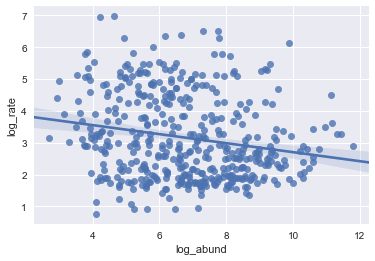

In [10]:
# Scatter plot of species-level grouped data
# Find mean abundances for species that appear in at least 10 plots
g = df[['spp','abund']].groupby('spp')
g = g.filter(lambda x: len(x) > 10).groupby('spp')
counts = g.aggregate('sum').sort_values('abund', ascending=False)

# Plot abundances versus metabolic rates
df4 = pd.merge(counts, df2, left_index=True, right_index=True)

df4['log_rate']  = np.log(df4.rate)
df4['log_abund'] = np.log(df4.abund)

plt.figure()
p=sns.regplot('log_abund', 'log_rate', data=df4)
model = sm.OLS(exog=sm.add_constant(df4.log_abund.values), endog=df4.log_rate.values)
print(model.fit().summary())

0.0640634604135992
0.006881639304240767
0.023050137296588228
0.00852986631062079
0.07996685802619954
0.05729905048001796
0.038998752182852724
0.08104802603297828
0.14293218691923867
0.051694227843686526
0.07449454060126197
0.01788186335151359
0.1318489635863811
0.19575062304847116
0.0196388933137345
0.17081563824642906
0.17078293642905382
0.016065508642435923
0.06362020784525135
0.08594359094319064
0.041873630080334553
0.0023879208581752565
0.13430027259862476
0.07629259860505085
0.03700976738057326
0.16006345065744662
0.12780254058895377
0.16780514633484228
0.3123945660633248
0.08376658955911244
0.09676983782290563
0.08961623635036152
0.044718335663329715
0.12236307975294412
0.05652098248219167
0.035969475043221386
0.08892613593923611
0.05085674147153843
0.25394928872068284
0.04902358414894134
0.0092596331786453
0.1622308148430183
0.18834843312135238
0.21403429423214224


array([0.03619034])

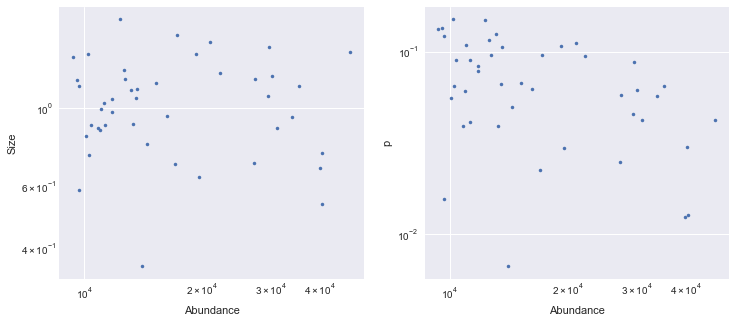

In [71]:
# Negative binomial fits for top 50 species
abundances, params0, params1 = [], [], []

for spp, abund in counts[6:50].iterrows():
    samp = df[df.spp == spp].abund.values
    res  = sm.NegativeBinomial(samp, np.ones_like(samp)).fit(disp=0)
    #print(samp)
    #plt.hist(samp, bins=100)
    #h = np.histogram(samp, bins=100)
    #print(h)
    #xs = np.arange(300)
    #plt.plot(xs, 350/((xs/13)**2+1))
    #plt.plot(xs, 70*np.exp(-xs/samp.mean()))
    #asdf
    mu   = np.exp(res.params[0])
    alpha = res.params[1]

    size = 1. / alpha 
    prob = size / (size + mu)
    abundances.append(int(abund))
    params0.append(size)
    params1.append(prob)
    print(size * prob / (1-prob))
    
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.loglog(abundances, params0, ls='none', marker='.')
plt.xlabel('Abundance') ; plt.ylabel('Size')
plt.subplot(1,2,2)
plt.loglog(abundances, params1, ls='none', marker='.')
plt.xlabel('Abundance') ; plt.ylabel('p')

param_model = sm.OLS(exog=sm.add_constant(abundances), endog=params1).fit()
param_model.predict([1,40000])

In [5]:
# Scatter plot of non-grouped data
if False:
    plt.figure()
    p=sns.regplot('log_abund', 'log_rate', data=df3)
    model = sm.OLS(exog=sm.add_constant(df3.log_abund.values), endog=df3.log_rate.values)
    print(model.fit().summary())
    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     317.5
Date:                Wed, 16 Oct 2019   Prob (F-statistic):           6.03e-54
Time:                        23:57:25   Log-Likelihood:                -854.22
No. Observations:                 445   AIC:                             1712.
Df Residuals:                     443   BIC:                             1721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5906      0.268    -28.291      0.0

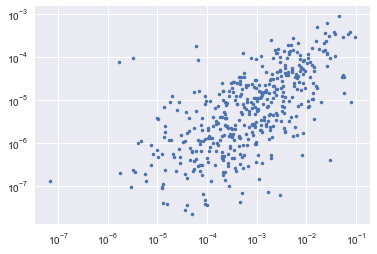

In [74]:
# Draw metabolic rates according to exponential distribution
beta = 120
abundances = df4.abund.values
metabolic_rates = np.array([np.random.exponential(1/(beta*x)) for x in abundances])

if False:
    model = sm.OLS(exog=sm.add_constant(np.log(abundances)), endog=np.log(metabolic_rates))
    print(model.fit().summary())
    plt.plot(abundances, metabolic_rates, ls='none', marker='.')

if False: # Poisson model
    samples = np.array([np.random.poisson(x) for x in abundances])
elif True: # Exponential model
    samples = np.array([np.random.exponential(1/x) for x in abundances])
else: # Negative binomial model
    predict_p = np.array([param_model.predict([1, x])[0] for x in abundances])
    predict_p[predict_p<0] = 0.001
    samples = np.array([np.random.negative_binomial(1, p) for p in predict_p])

endog = np.log(metabolic_rates)[samples > 0]
exog = np.log(samples)[samples > 0 ]

model = sm.OLS(exog=sm.add_constant(exog), endog=endog)
print(model.fit().summary())
plt.loglog(samples, metabolic_rates, ls='none', marker='.')

In [ ]:
# Draw metabolic rates according to exponential distribution
beta = 120.
metabolic_rates = np.array([np.random.exponential(1/(beta*x)) for x in abundances])

# Print coefficient
model = sm.OLS(np.log(abundances),np.log(metabolic_rates))
print(model.fit().summary())

# Plot in log log
plt.figure() ; plt.loglog(abundances, metabolic_rates, ls='none', marker='.')


# Draw plot counts according to negative binomial distribution
plt.figure()
samples = np.array([np.random.negative_binomial(1, 0.02) for x in abundances])
metabolic_rates2 = metabolic_rates[samples > 0]
samples = samples[samples > 0]
plt.loglog(samples, metabolic_rates2, ls='none', marker='.')
model = sm.OLS(np.log(samples),np.log(metabolic_rates2))
print(model.fit().summary())
#X = np.log(samples)
#model = sm.OLS(np.log(samples),X)
#print(model.fit().summary())